# Introduction

In this tutorial we show how to use the python SDK to use basic resource types including assets and time series.

In [1]:
import os
from datetime import datetime, timedelta
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cognite.client import CogniteClient

In [2]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "),
                       project="publicdata", client_name="Python SDK Intro")

Open Industrial Data API-KEY: ········


## 2. Retrieving Lists of Assets

### List assets
The `client.assets.list(limit=20)` function retrieves the first `limit` assets, and returns it as an `AssetList`.

In [3]:
client.assets.list(limit=20)

,name,parent_id,description,metadata,id,created_time,last_updated_time,root_id
0,23-TE-96116-04,3117826349444493,VRD - PH 1STSTGGEAR THRUST BRG OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '525283', ...",702630644612,0,0,6687602007296940
1,23-TE-96148,8515799768286580,VRD - PH 1STSTG COMP SEAL GAS HTR,"{'ELC_STATUS_ID': '1211', 'RES_ID': '532924', ...",5156972057719,0,0,6687602007296940
2,23-YT-96117-01,3257705896277160,VRD - PH 1STSTGGEAR 1 JOURNBRG DE,"{'ELC_STATUS_ID': '1211', 'RES_ID': '446683', ...",8019487489463,0,0,6687602007296940
3,23-FI-96151,4239585628663887,SOFT TAG VRD - PH 1STSTG PRIM SEAL LEAK DE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",9258567430091,0,0,6687602007296940
4,23-LT-92521,2069232457199305,VRD - PH 1STSTGSUCTSCRUBBER LEVEL,"{'ELC_STATUS_ID': '1211', 'RES_ID': '523206', ...",12670864495024,0,0,6687602007296940
5,23-EZSM-92501A,576308321452985,VRD - PH 1STSTGSUCTCLR GAS IN,"{'ELC_STATUS_ID': '1211', 'RES_ID': '145665', ...",13001911877650,0,0,6687602007296940
6,23-TAHH-96115-01,1491649372046525,VRD - PH 1STSTGGEAR THRUST BRG IN : TEMPERATUR...,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",26731253648529,0,0,6687602007296940
7,23-LEX-92529,1081261865374641,VRD - PH 1STSTGSCRUB I-FACE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",38840252674561,0,0,6687602007296940
8,23-TE-96131-01,6191827428964450,VRD - PH 1STSTG MOTOR JOURN BRG NDE,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",40737621439156,0,0,6687602007296940
9,23-FO-96188,2357112351749647,VRD - PH 1STSTG LUBE OIL PURGE GAS,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",49184996243859,0,0,6687602007296940


## Search Assets
The `client.assets.search()` function allows you to search by a specific property of the asset, including its name, parent, etc.

### Fuzzy Search by name
The search by name includes results that are similar in name, but not an exact match.

In [4]:
asset_name = "23-HA-9103"
assets = client.assets.search(name=asset_name)
assets[:5]

,name,parent_id,description,metadata,id,created_time,last_updated_time,root_id
0,23-HA-9103,2513266419866445,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",2861239574637735,0,0,6687602007296940
1,23-KB-9103,3904753668320840,VRD - 1ST STAGE COMPRESSOR SEAL GAS PRESSURE B...,"{'ELC_STATUS_ID': '1211', 'RES_ID': '476494', ...",3089052537026304,0,0,6687602007296940
2,23-TX-9103,2137557577165478,VRD - 1ST STAGE COMPPRESSOR LUBE OIL RESERVOIR,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",2357112351749647,0,0,6687602007296940
3,23-HA-9107A,2137557577165478,VRD - 1ST STAGE COMPRESSOR LUBE OIL COOLER A,"{'ELC_STATUS_ID': '1211', 'RES_ID': '786890', ...",4965752723543746,0,0,6687602007296940
4,23-HA-9107B,2137557577165478,VRD - 1ST STAGE COMPRESSOR LUBE OIL COOLER B,"{'ELC_STATUS_ID': '1211', 'RES_ID': '786896', ...",6838563873305104,0,0,6687602007296940


### Specific Search
The `client.assets.retrieve()` interface provides the same information for one specific asset based on the provided ID or external ID.

In [5]:
asset_id = [a.id for a in assets if a.name==asset_name][0]
client.assets.retrieve(id=asset_id)

,value
name,23-HA-9103
parent_id,2513266419866445
description,VRD - 1ST STAGE SUCTION COOLER
id,2861239574637735
created_time,0
last_updated_time,0
root_id,6687602007296940
ELC_STATUS_ID,1211
RES_ID,531306
SOURCE_DB,workmate


## 3. Asset Hierarchy and Relationships

We will generate a list of all children of the main asset of interest. The main asset of interest is listed first, then the children are listed underneath in following rows.

In [6]:
subtree = client.assets.retrieve_subtree(id=asset_id)
subtree[:5]

,name,parent_id,description,metadata,id,created_time,last_updated_time,root_id
0,23-HA-9103,2513266419866445,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",2861239574637735,0,0,6687602007296940
1,45-HV-92510-01,2861239574637735,VRD - PH 1STSTGSUCTCOOL SHELL PSV IN,"{'ELC_STATUS_ID': '1225', 'RES_ID': '444134', ...",274450897701725,0,0,6687602007296940
2,23-ESDV-92501A,2861239574637735,VRD - PH 1STSTGSUCTCLR GAS IN,"{'ELC_STATUS_ID': '1211', 'RES_ID': '609895', ...",576308321452985,0,0,6687602007296940
3,45-HV-92510-03,2861239574637735,VRD - PH 1STSTGSUCTCOOL SHELL PSV OUT,"{'ELC_STATUS_ID': '1225', 'RES_ID': '510103', ...",619750565594754,0,0,6687602007296940
4,45-PT-92508,2861239574637735,VRD - PH 1STSTGSUCTCOOL COOLMED OUT,"{'ELC_STATUS_ID': '1211', 'RES_ID': '485917', ...",705952550422793,0,0,6687602007296940


## 4. Collecting Time Series Data

###Compile a list of time series objects under the asset
For each of the assets in the subtree we retrieved, we get the associated time series objects and merge them into a single `TimeSeriesList` object.

In [7]:
all_timeseries = subtree.time_series()
print(len(all_timeseries),'time series in subtree')
all_timeseries[:5]

37 time series in subtree


,id,external_id,name,is_string,metadata,asset_id,is_step,description,created_time,last_updated_time
0,605574483685900,VAL_23_PIC_92538_06:Z.X.Value,VAL_23_PIC_92538_06:Z.X.Value,False,"{'tag': 'VAL_23_PIC_92538_06:Z.X.Value', 'scan...",66838572336451,False,PH 1stStgComp STV Perf Limit 1 PV,0,0
1,772308035614768,VAL_23-TIC-92504:Z.Y.Value,VAL_23-TIC-92504:Z.Y.Value,False,"{'tag': 'VAL_23-TIC-92504:Z.Y.Value', 'scan': ...",4767966442976218,False,PH 1stStgSuctCool Gas Out Output,0,0
2,988967451935968,VAL_23-TT-92512:X.Value,VAL_23-TT-92512:X.Value,False,"{'tag': 'VAL_23-TT-92512:X.Value', 'scan': '1'...",5439867226448359,False,PH 1stStgSuctCool Gas In,0,0
3,1804879717768950,VAL_45-PDT-92506:X.Value,VAL_45-PDT-92506:X.Value,False,"{'tag': 'VAL_45-PDT-92506:X.Value', 'scan': '1...",7835659687560027,False,PH 1stStgSuctCool Shell,0,0
4,1831771645999315,VAL_23-TIC-92504:Control Module:YR,VAL_23-TIC-92504:Control Module:YR,False,"{'tag': 'VAL_23-TIC-92504:Control Module:YR', ...",4767966442976218,True,PH 1stStgSuctCool Gas Out Working Setpoint,0,0


If you are curious about which asset a time series is attached to, you can retrieve more information of the asset by using the retrieve function. Note that the property is called `asset_id` following typical python style, while `assetId` is used in the underlying API objects and tabular outputs.

In [8]:
client.assets.retrieve(id=all_timeseries[0].asset_id)

,value
name,23-PIC-92538-06
parent_id,3956345651792907
description,SOFT TAG VRD - PH 1STSTGCOMP SUCTION STV
id,66838572336451
created_time,0
last_updated_time,0
root_id,6687602007296940
ELC_STATUS_ID,1211
SOURCE_DB,workmate
SOURCE_TABLE,wmate_dba.wmt_tag


### View datapoints for specific time series
The identifier to retrieve Datapoints is the externalId column from the output above.

In [9]:
client.datapoints.retrieve(external_id="VAL_23-FT-92537-01:X.Value", start="10d-ago", end="now")[:10]

,VAL_23-FT-92537-01:X.Value
2019-11-29 14:17:30.105,166124.156250
2019-11-29 14:17:40.107,165284.218750
2019-11-29 14:17:51.110,165558.031250
2019-11-29 14:18:00.108,166148.781250
2019-11-29 14:18:11.111,166695.640625
2019-11-29 14:18:21.116,164419.890625
2019-11-29 14:18:31.109,159430.812500
2019-11-29 14:18:42.103,162179.718750
2019-11-29 14:18:52.103,158192.765625
2019-11-29 14:19:02.111,160885.234375


## 5. Use Cases of CDF Data

### Collect datapoints from CDF
The time series names are defined in the in_ts_names and out_ts_names lists below.

In [10]:
in_ts_names = ["VAL_23-FT-92512:X.Value", "VAL_23-PT-92512:X.Value", "VAL_23-TT-92502:X.Value"]
out_ts_name = "VAL_23-PT-92504:X.Value"

### Retrieve Data Points from CDF
Most object types in the Python SDK have a `to_pandas` method which converts the result to a pandas dataframe. For retrieving aggregates such as the average over each time period, you can use `client.datapoints.retrieve_dataframe` to get a pandas dataframe directly. 

In [11]:
ts_names = in_ts_names + [out_ts_name]

train_start_date = datetime(2018, 8, 1)

train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.retrieve_dataframe(external_id=ts_names,
                                                     aggregates=['average'],
                                                     granularity='1m',
                                                     start=train_start_date,
                                                     end=train_end_date,
                                                     include_aggregate_name=False
                                                     )
datapoints_df.fillna(method="ffill", inplace=True)
datapoints_df.head()

,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


There are also shortcuts for filling the dataframe when using interpolation or count aggregates. Note that without the `include_aggregate_name=False` option, the aggregate name is appended to the external id to form a unique column name.

In [12]:
datapoints_df_interp = client.datapoints.retrieve_dataframe(external_id=ts_names[0:2],
                                                           aggregates=['interpolation','count'],
                                                           granularity='1h',
                                                           start=train_start_date,
                                                           end=train_end_date,
                                                           complete="fill")
datapoints_df_interp.head()

,VAL_23-FT-92512:X.Value|count,VAL_23-FT-92512:X.Value|interpolation,VAL_23-PT-92512:X.Value|count,VAL_23-PT-92512:X.Value|interpolation
2018-08-01 00:00:00,3522,88106.726602,2853,3.332684
2018-08-01 01:00:00,3517,88266.907953,2852,3.474739
2018-08-01 02:00:00,3535,93328.063281,2810,3.431560
2018-08-01 03:00:00,3521,77838.162189,2836,3.209425
2018-08-01 04:00:00,3516,86494.803008,2847,3.394040


### Visualize the Time Series Data
The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

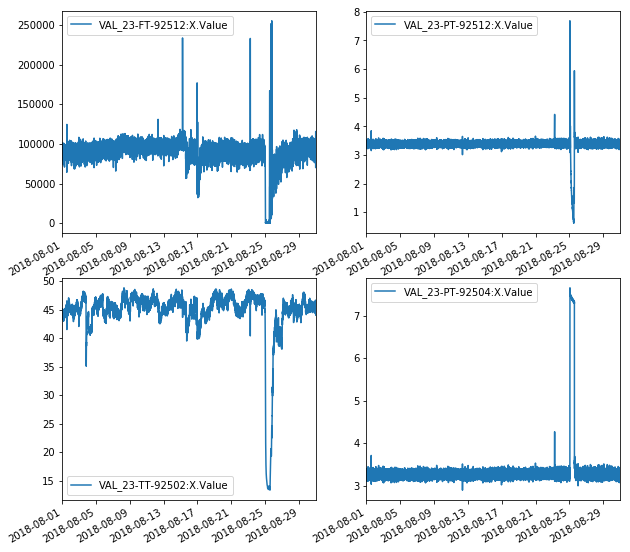

In [13]:
cols = datapoints_df.columns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    datapoints_df.loc[:, [col]].plot(ax=axes.ravel()[i])

## 6. Model Creation

In [14]:
train_X = datapoints_df[in_ts_names].to_numpy()
train_y = datapoints_df[out_ts_name].to_numpy()

### Get a separate DataFrame from CDF
The data which we will use to predict the output pressure will be stored in a seperate dataframe as collected below.

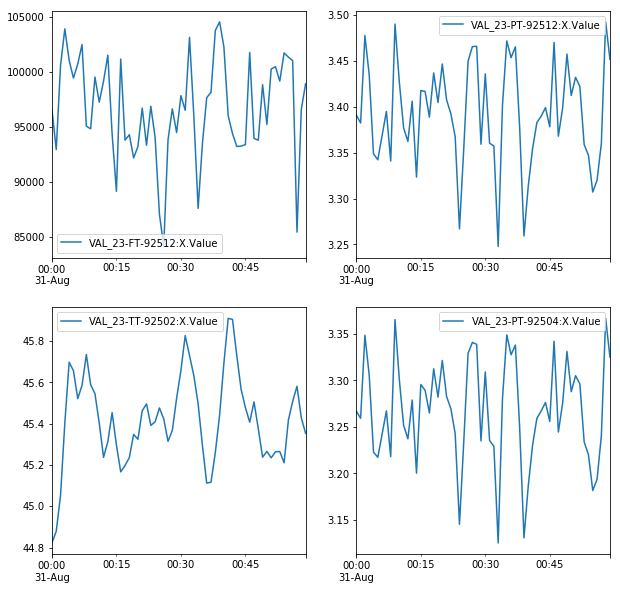

In [15]:
predict_start_date = train_end_date
predict_end_date = train_end_date + timedelta(hours=1)
predict_df = client.datapoints.retrieve_dataframe(
    external_id=ts_names,
    aggregates=['average'],
    granularity='1m',
    start=predict_start_date,
    end=predict_end_date,
    include_aggregate_name=False
)
predict_df.fillna(method="ffill", inplace = True)
predict_df.head()

cols = predict_df.columns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    predict_df.plot(y=col, ax=axes.ravel()[i]);

## 7. Linear Regression Model
As a simple starting point we will check to see how a linear regression model performs to predict the output pressure.

### Utilize sklearn to create a basic linear regression model
Sklearn is common package utilized to import and deploy data science models. Linear Regression is only one of many options for constructing models.


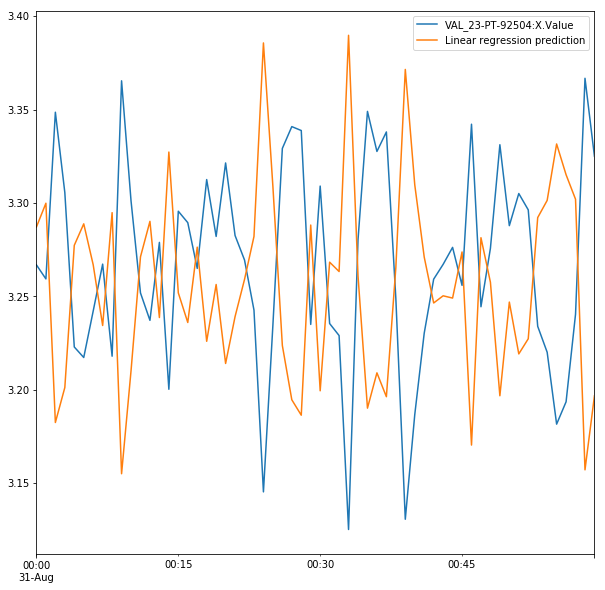

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)
predict_df["Linear regression prediction"] = lin_reg.predict(predict_df[in_ts_names])
predict_df.plot(y=[out_ts_name, "Linear regression prediction"], figsize=(10,10));